# Loopy (recurrent) neural networks (RNNs)

Creating memory in a neural net

Building a recurrent neural net

Data handling for RNNs

Backpropagating through time (BPTT)

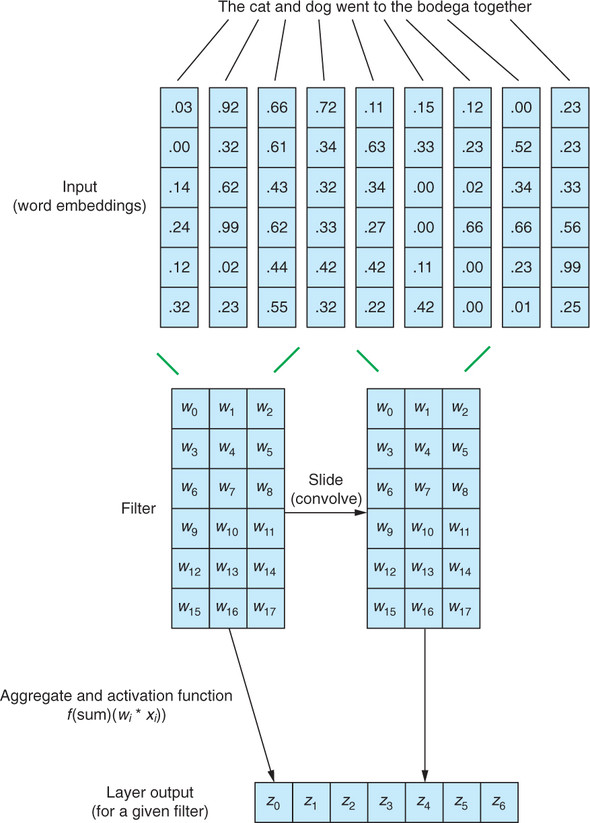

1D convolution with embeddings

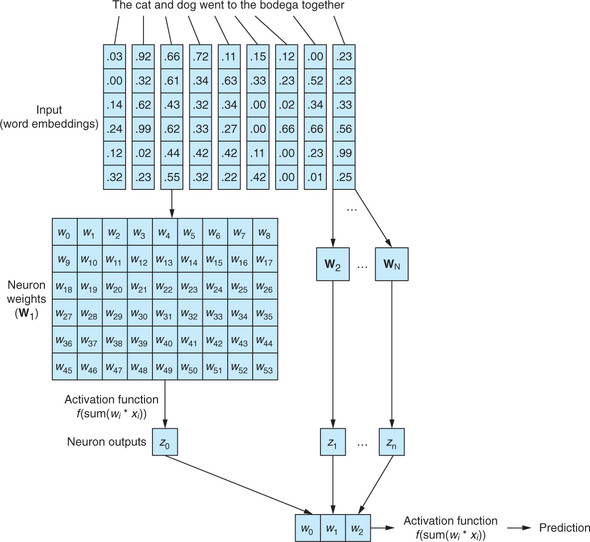

 Text into a feedforward network

## Remembering with recurrent networks

The stolen car sped into the arena.


The clown car sped into the arena.

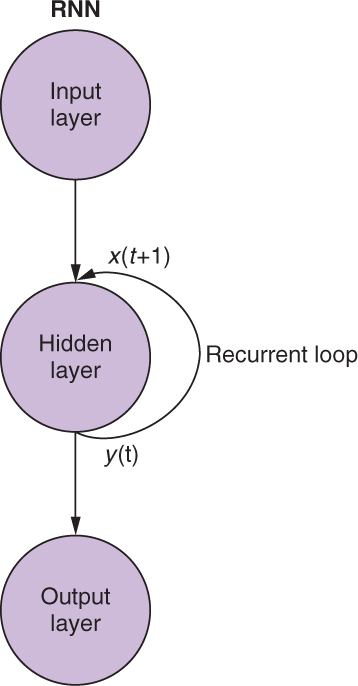

Recurrent neural net

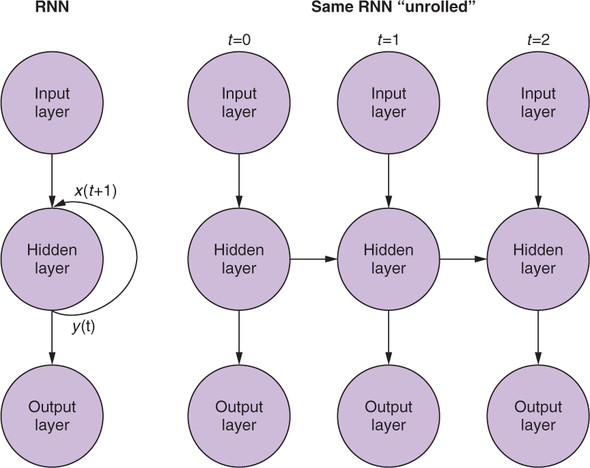

Unrolled recurrent neural net

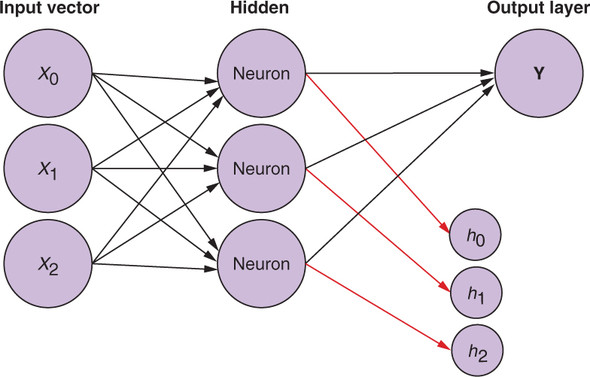

Detailed recurrent neural net at time step t = 0

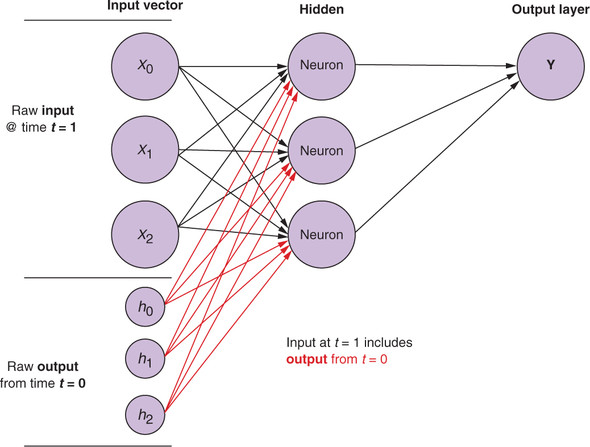

Detailed recurrent neural net at time step t = 1

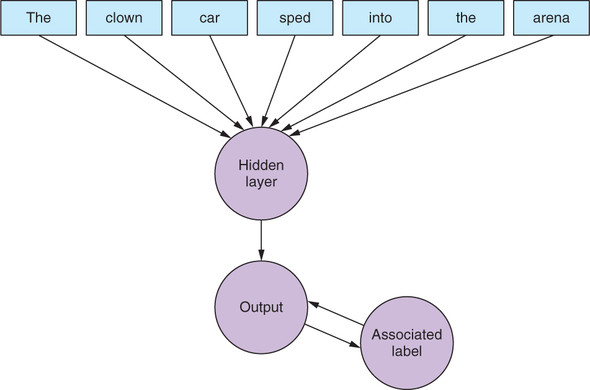

Data into convolutional network

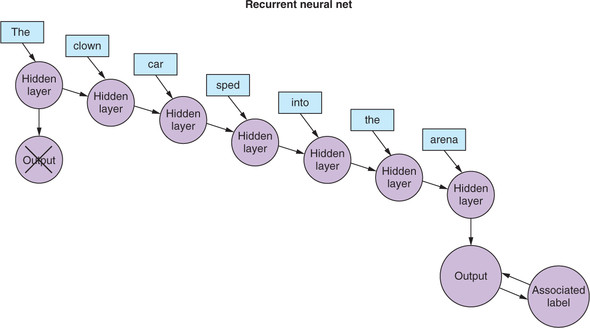

Data fed into a recurrent network

## Backpropagation through time

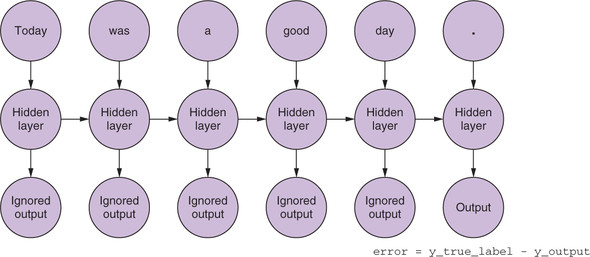

Only last output matters here

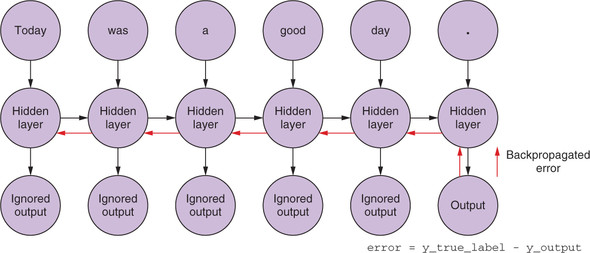

 Backpropagation through time

### But you do care what came out of the earlier steps

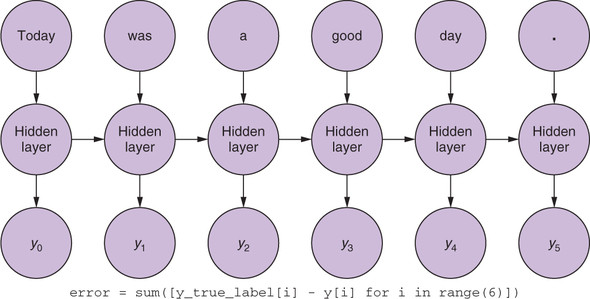

All outputs matter here

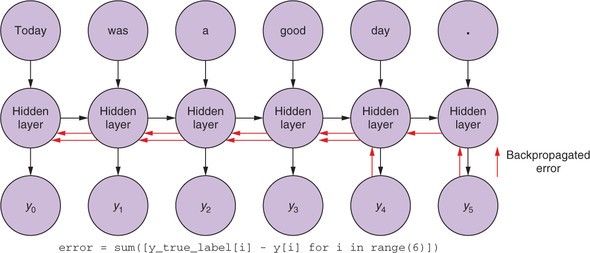

Multiple outputs and backpropagation through time

## Recurrent neural net with Keras

In [ ]:
# Import all the things

>>> import glob
>>> import os
>>> from random import shuffle
>>> from nltk.tokenize import TreebankWordTokenizer
>>> from nlpia.loaders import get_data
>>> word_vectors = get_data('wv')

In [ ]:
# Data preprocessor

>>> def pre_process_data(filepath):
...     """
...     Load pos and neg examples from separate dirs then shuffle them
...     together.
...     """
...     positive_path = os.path.join(filepath, 'pos')
...     negative_path = os.path.join(filepath, 'neg')
...     pos_label = 1
...     neg_label = 0
...     dataset = []
...     for filename in glob.glob(os.path.join(positive_path, '*.txt')):
...         with open(filename, 'r') as f:
...             dataset.append((pos_label, f.read()))
...     for filename in glob.glob(os.path.join(negative_path, '*.txt')):
...         with open(filename, 'r') as f:
...             dataset.append((neg_label, f.read()))
...     shuffle(dataset)
...     return dataset

In [ ]:
# Data tokenizer + vectorizer

>>> def tokenize_and_vectorize(dataset):
...     tokenizer = TreebankWordTokenizer()
...     vectorized_data = []
...     for sample in dataset:
...         tokens = tokenizer.tokenize(sample[1])
...         sample_vecs = []
...         for token in tokens:
...             try:
...                 sample_vecs.append(word_vectors[token])
...             except KeyError:
...                 pass
...         vectorized_data.append(sample_vecs)
...     return vectorized_data

In [ ]:
# Target unzipper

>>> def collect_expected(dataset):
...     """ Peel off the target values from the dataset """
...     expected = []
...     for sample in dataset:
...         expected.append(sample[0])
...     return expected

In [ ]:
# Load and prepare your data

>>> dataset = pre_process_data('./aclimdb/train')
>>> vectorized_data = tokenize_and_vectorize(dataset)
>>> expected = collect_expected(dataset)
>>> split_point = int(len(vectorized_data) * .8)
>>> x_train = vectorized_data[:split_point]
>>> y_train = expected[:split_point]
>>> x_test = vectorized_data[split_point:]
>>> y_test = expected[split_point:]

In [ ]:
# Initialize your network parameters

>>> maxlen = 400
>>> batch_size = 32
>>> embedding_dims = 300
>>> epochs = 2

In [ ]:
# Load your test and training data

>>> import numpy as np

>>> x_train = pad_trunc(x_train, maxlen)
>>> x_test = pad_trunc(x_test, maxlen)

>>> x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
>>> y_train = np.array(y_train)
>>> x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
>>> y_test = np.array(y_test)

In [ ]:
# Initialize an empty Keras network

>>> from keras.models import Sequential
>>> from keras.layers import Dense, Dropout, Flatten, SimpleRNN
>>> num_neurons = 50
>>> model = Sequential()

In [ ]:
#  Add a recurrent layer

>>> model.add(SimpleRNN(
...    num_neurons, return_sequences=True,
...    input_shape=(maxlen, embedding_dims)))

In [ ]:
# Add a dropout layer

>>> model.add(Dropout(.2))

>>> model.add(Flatten())
>>> model.add(Dense(1, activation='sigmoid'))

###  Putting things together

In [ ]:
# Compile your recurrent network

>>> model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
Using TensorFlow backend.
>>> model.summary()
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
simple_rnn_1 (SimpleRNN)     (None, 400, 50)           17550
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 50)           0
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 20001
=================================================================
Total params: 37,551.0
Trainable params: 37,551.0
Non-trainable params: 0.0
_________________________________________________________________
None

### Let’s get to learning our past selves

In [ ]:
#  Train and save your model

>>> model.fit(x_train, y_train,
...           batch_size=batch_size,
...           epochs=epochs,
...           validation_data=(x_test, y_test))
Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 215s - loss: 0.5723 -
acc: 0.7138 - val_loss: 0.5011 - val_acc: 0.7676
Epoch 2/2
20000/20000 [==============================] - 183s - loss: 0.4196 -
acc: 0.8144 - val_loss: 0.4763 - val_acc: 0.7820

>>> model_structure = model.to_json()
>>> with open("simplernn_model1.json", "w") as json_file:
...     json_file.write(model_structure)
>>> model.save_weights("simplernn_weights1.h5")
Model saved.

### Hyperparameters

In [ ]:
# Model parameters

>>> maxlen = 400
>>> embedding_dims = 300
>>> batch_size = 32
>>> epochs = 2
>>> num_neurons = 50

In [ ]:
# Build a larger network

>>> num_neurons = 100
>>> model = Sequential()
>>> model.add(SimpleRNN(
...     num_neurons, return_sequences=True, input_shape=(maxlen,\
...     embedding_dims)))
>>> model.add(Dropout(.2))
>>> model.add(Flatten())
>>> model.add(Dense(1, activation='sigmoid'))
>>> model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
Using TensorFlow backend.
>>> model.summary()
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
simple_rnn_1 (SimpleRNN)     (None, 400, 100)          40100
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 100)          0
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 40001
=================================================================
Total params: 80,101.0
Trainable params: 80,101.0
Non-trainable params: 0.0
_________________________________________________________________

In [ ]:
#  Train your larger network

>>> model.fit(x_train, y_train,
...           batch_size=batch_size,
...           epochs=epochs,
...           validation_data=(x_test, y_test))
Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 287s - loss: 0.9063 -
acc: 0.6529 - val_loss: 0.5445 - val_acc: 0.7486
Epoch 2/2
20000/20000 [==============================] - 240s - loss: 0.4760 -
acc: 0.7951 - val_loss: 0.5165 - val_acc: 0.7824
>>> model_structure = model.to_json()
>>> with open("simplernn_model2.json", "w") as json_file:
...     json_file.write(model_structure)
>>> model.save_weights("simplernn_weights2.h5")
Model saved.

In [ ]:
# num_neurons set to 25:

20000/20000 [==============================] - 240s - loss: 0.5394 -
acc: 0.8084 - val_loss: 0.4490 - val_acc: 0.7970

### Predicting

In [ ]:
#  Crummy weather sentiment

>>> sample_1 = "I hate that the dismal weather had me down for so long, when
➥ will it break! Ugh, when does happiness return? The sun is blinding and 
➥ the puffy clouds are too thin. I can't wait for the weekend."
 
>>> from keras.models import model_from_json
>>> with open("simplernn_model1.json", "r") as json_file:
...     json_string = json_file.read()
>>> model = model_from_json(json_string)
>>> model.load_weights('simplernn_weights1.h5')
 
>>> vec_list = tokenize_and_vectorize([(1, sample_1)])
>>> test_vec_list = pad_trunc(vec_list, maxlen)
>>> test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen,\
...     embedding_dims))
 
>>> model.predict_classes(test_vec)
array([[0]], dtype=int32)

###  Two-way street

They wanted to pet the dog whose fur was brown.

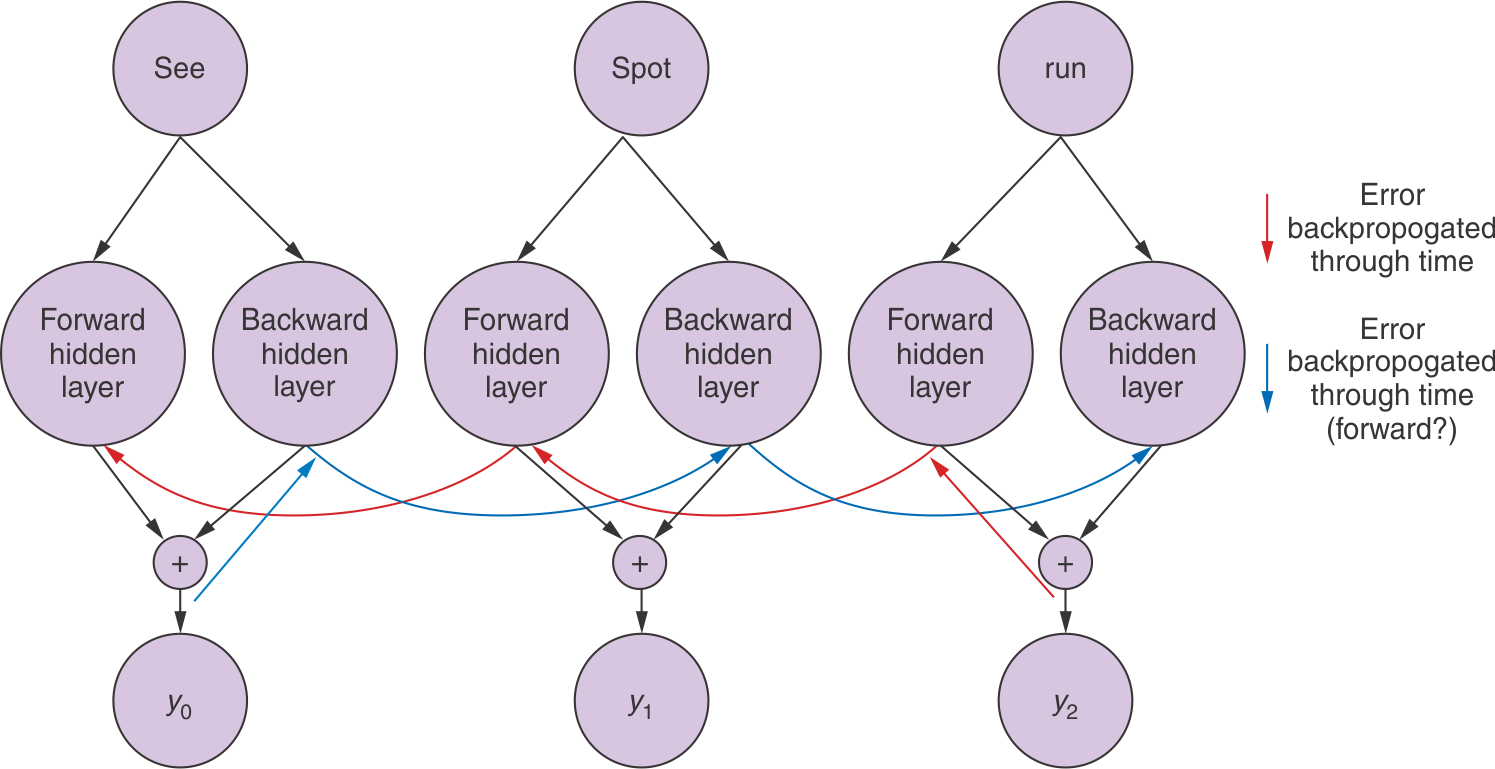

 Bidirectional recurrent neural net

In [ ]:
# Build a Bidirectional recurrent network

>>> from keras.models import Sequential
>>> from keras.layers import SimpleRNN
>>> from keras.layers.wrappers import Bidirectional

>>> num_neurons = 10
>>> maxlen = 100
>>> embedding_dims = 300

>>> model = Sequential()
>>> model.add(Bidirectional(SimpleRNN(
...    num_neurons, return_sequences=True),\
...    input_shape=(maxlen, embedding_dims)))

# Improving retention with long short-term memory networks (LSTM)

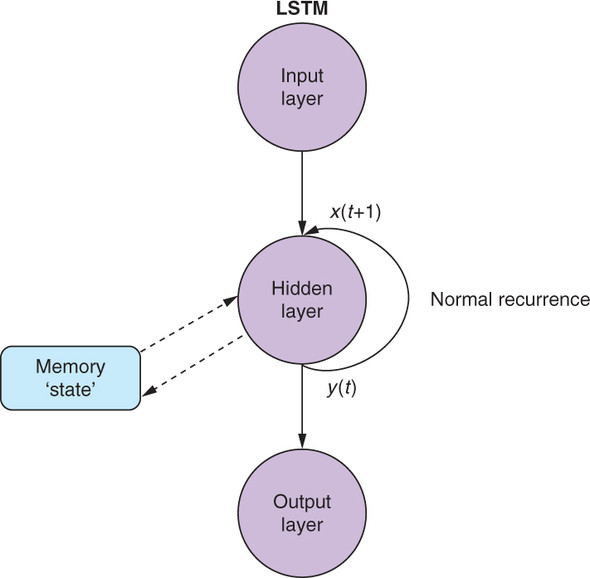

 LSTM network and its memory

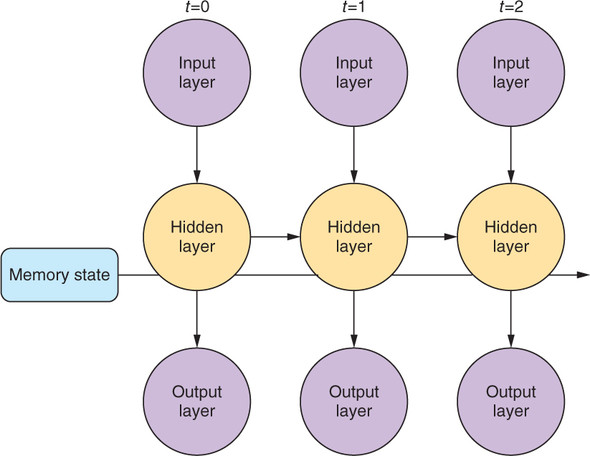

Unrolled LSTM network and its memory


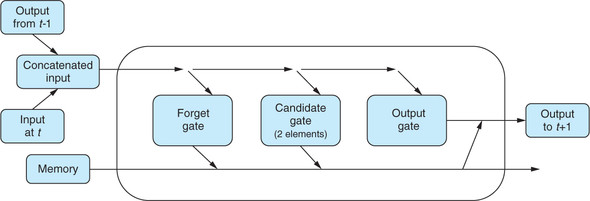

 LSTM layer at time step t